# Imports and Installation

In [1]:
!pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.metrics import log_loss
import pickle
import networkx as nx
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

D:\Anaconda\envs\cse150a\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read Data

In [2]:
train_df = pd.read_csv('final_train.csv')
test_df = pd.read_csv('final_test.csv')

In [3]:
targets = ['Direction_quarter', 'Trend_class']
features = []

for col in train_df.columns:
    if col not in targets:
        features.append(col)

In [4]:
edges = ([(feat, targets[0]) for feat in features] +
         [(feat, targets[1]) for feat in features] +
         [(targets[0], targets[1])])

# Sanity Check

In [5]:
G = nx.DiGraph(edges)
if nx.is_directed_acyclic_graph(G):
    print("Graph is a valid DAG")
else:
    print("Cycle detected")

Graph is a valid DAG


# Model Training

In [9]:
# bn1= BayesianNetwork(edges)
# bn1.fit(train_df, estimator=MaximumLikelihoodEstimator)
# infer1 = VariableElimination(bn1)

# with open('bn1_model.pkl', 'wb') as f:
#     pickle.dump(bn1, f)

In [6]:
# blacklist = [(target, node) for target in targets for node in train_df.columns if node != target]
invalid_edges = [
    ('Trend_class', 'Direction_quarter'),
    ('Direction_quarter', 'Year_bin')
]

hc = HillClimbSearch(train_df)
# best_model = hc.estimate(scoring_method=BicScore(train_df), black_list=blacklist)
best_model = hc.estimate(scoring_method=BicScore(train_df))

required_edges = [(feature, 'Direction_quarter') for feature in features if feature not in best_model.nodes()]
required_edges += [(feature, 'Trend_class') for feature in features if feature not in best_model.nodes()]
best_model.add_edges_from(required_edges)
cleaned_edges = [edge for edge in best_model.edges() if edge not in invalid_edges]
best_model = BayesianNetwork(cleaned_edges)

bn2 = BayesianNetwork(best_model.edges())

if not nx.is_directed_acyclic_graph(bn2):
    raise ValueError("BN2 contains cycles")

bn2.fit(train_df, estimator=MaximumLikelihoodEstimator)
infer2 = VariableElimination(bn2)

with open('bn2_model.pkl', 'wb') as f:
    pickle.dump(bn2, f)

  0%|          | 14/1000000 [00:00<7:01:25, 39.55it/s]


C:\Users\Charlie Shang\AppData\Local\Temp\ipykernel_43892\1959849907.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


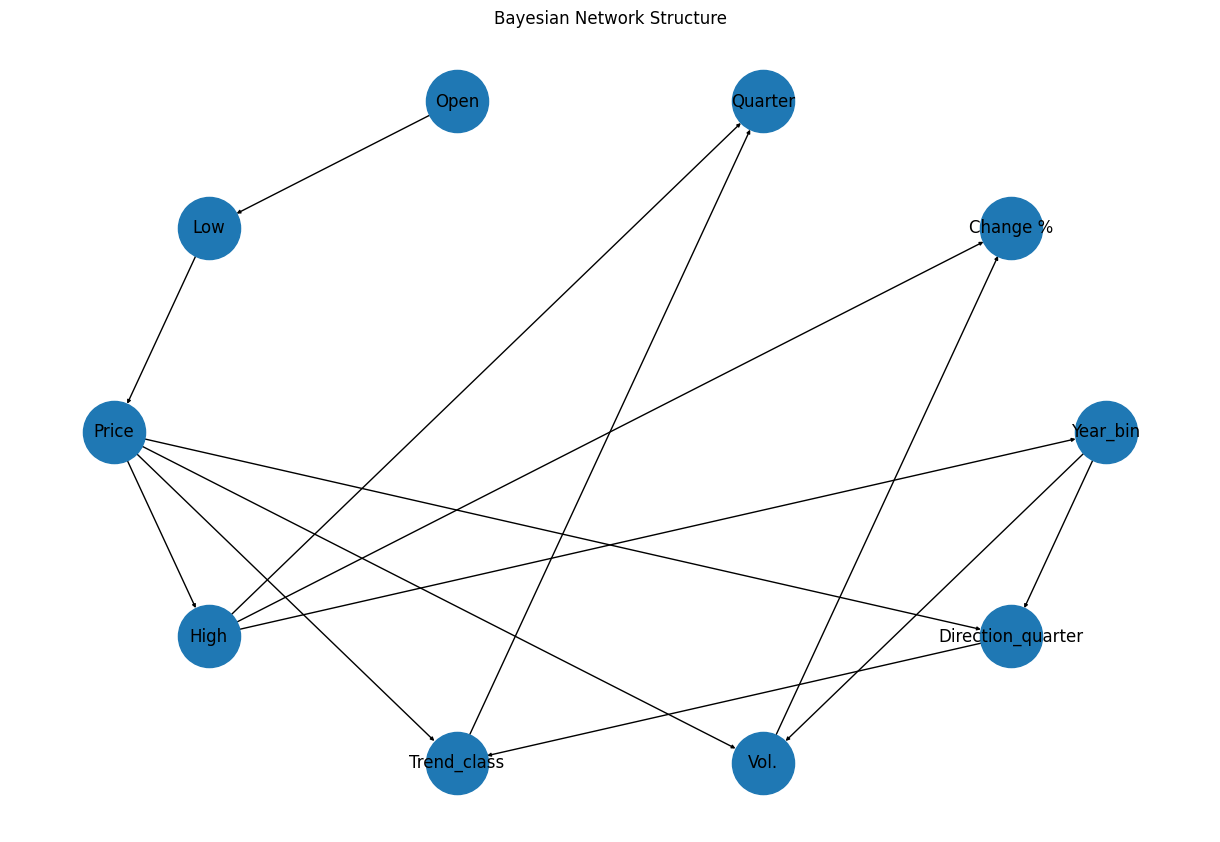

In [22]:
bn2_edges = bn2.edges()

G = nx.DiGraph()
G.add_edges_from(bn2_edges)

plt.figure(figsize=(12, 8))
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, arrowsize=5)
plt.title("Bayesian Network Structure")
plt.tight_layout()
plt.savefig('structure.png', bbox_inches='tight')
plt.show()

# CPTs Generation

In [8]:
with open("bn1_model.pkl", "rb") as f:
    bn1 = pickle.load(f)

with open("bn2_model.pkl", "rb") as f:
    bn2 = pickle.load(f)
    
cpds1 = bn1.get_cpds()
cpds2 = bn2.get_cpds()

In [9]:
# directions_cpd1 = bn1.get_cpds("Direction_quarter")
# print(directions_cpd1)
# print()
directions_cpd = bn2.get_cpds("Direction_quarter")
print(directions_cpd)

+----------------------+-----+---------------------+
| Price                | ... | Price(4)            |
+----------------------+-----+---------------------+
| Year_bin             | ... | Year_bin(4)         |
+----------------------+-----+---------------------+
| Direction_quarter(0) | ... | 0.37209302325581395 |
+----------------------+-----+---------------------+
| Direction_quarter(1) | ... | 0.627906976744186   |
+----------------------+-----+---------------------+


In [10]:
trends_cpd = bn2.get_cpds("Trend_class")
print(trends_cpd)

+-------------------+-----+----------------------+
| Direction_quarter | ... | Direction_quarter(1) |
+-------------------+-----+----------------------+
| Price             | ... | Price(4)             |
+-------------------+-----+----------------------+
| Trend_class(0)    | ... | 0.0                  |
+-------------------+-----+----------------------+
| Trend_class(1)    | ... | 0.00684931506849315  |
+-------------------+-----+----------------------+
| Trend_class(2)    | ... | 0.0                  |
+-------------------+-----+----------------------+
| Trend_class(3)    | ... | 0.0                  |
+-------------------+-----+----------------------+
| Trend_class(4)    | ... | 0.0                  |
+-------------------+-----+----------------------+
| Trend_class(5)    | ... | 0.9931506849315068   |
+-------------------+-----+----------------------+


In [11]:
all_cpds = bn2.get_cpds()
for cpd in all_cpds:
    filename = f"{cpd.variable}.csv"
    cpd.to_csv(filename = filename)
    df_cpd = pd.read_csv(filename)
    # print(df_cpd)
    # print()

In [16]:
df_directions_cpd = pd.read_csv("Direction_quarter.csv")
df_trends_cpd = pd.read_csv("Trend_class.csv")

In [17]:
df_directions_cpd

,Price,Price(0),Price(0).1,Price(0).2,Price(0).3,Price(0).4,Price(1),Price(1).1,Price(1).2,Price(1).3,...,Price(3),Price(3).1,Price(3).2,Price(3).3,Price(3).4,Price(4),Price(4).1,Price(4).2,Price(4).3,Price(4).4
0,Year_bin,Year_bin(0),Year_bin(1),Year_bin(2),Year_bin(3),Year_bin(4),Year_bin(0),Year_bin(1),Year_bin(2),Year_bin(3),...,Year_bin(0),Year_bin(1),Year_bin(2),Year_bin(3),Year_bin(4),Year_bin(0),Year_bin(1),Year_bin(2),Year_bin(3),Year_bin(4)
1,Direction_quarter(0),0.5038860103626943,0.4234620886981402,0.2,0.5,0.5,0.38998211091234347,0.45230439442658094,0.30441400304414,0.5,...,0.5,0.5,0.45454545454545453,0.2809667673716012,0.2911392405063291,0.5,0.5,0.5,0.5641025641025641,0.37209302325581395
2,Direction_quarter(1),0.4961139896373057,0.5765379113018598,0.8,0.5,0.5,0.6100178890876565,0.5476956055734191,0.69558599695586,0.5,...,0.5,0.5,0.5454545454545454,0.7190332326283988,0.7088607594936709,0.5,0.5,0.5,0.4358974358974359,0.627906976744186


In [18]:
df_trends_cpd

,Direction_quarter,Direction_quarter(0),Direction_quarter(0).1,Direction_quarter(0).2,Direction_quarter(0).3,Direction_quarter(0).4,Direction_quarter(1),Direction_quarter(1).1,Direction_quarter(1).2,Direction_quarter(1).3,Direction_quarter(1).4
0,Price,Price(0),Price(1),Price(2),Price(3),Price(4),Price(0),Price(1),Price(2),Price(3),Price(4)
1,Trend_class(0),0.11357340720221606,0.04642857142857143,0.1572093023255814,0.0791599353796446,0.0058823529411764705,0.0,0.0,0.0,0.0,0.0
2,Trend_class(1),0.0,0.0,0.0,0.0,0.0,0.24315352697095435,0.07104660045836517,0.16602316602316602,0.04236200256739409,0.00684931506849315
3,Trend_class(2),0.23915050784856878,0.12976190476190477,0.2427906976744186,0.17124394184168013,0.011764705882352941,0.0,0.0,0.0,0.0,0.0
4,Trend_class(3),0.0,0.0,0.0,0.0,0.0,0.3228215767634855,0.1917494270435447,0.2828185328185328,0.17394094993581516,0.0
5,Trend_class(4),0.4293628808864266,0.65,0.5562790697674419,0.7415185783521809,0.9764705882352941,0.0,0.0,0.0,0.0,0.0
6,Trend_class(5),0.21791320406278855,0.1738095238095238,0.04372093023255814,0.008077544426494346,0.0058823529411764705,0.4340248962655602,0.7372039724980901,0.5511583011583011,0.7836970474967908,0.9931506849315068


# Model Evaluation

In [12]:
def evaluate(y_true, y_pred, target_name, probs, state_names):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    
    label_indices = [state_names.index(label) for label in y_true]
    prob_matrix = np.array([[p[i] for i in range(len(state_names))] 
                          for p in probs])
    ll = log_loss(y_true, prob_matrix, labels=state_names)
    
    print(f"{target_name} Evaluation:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Log Loss: {ll if isinstance(ll, str) else f'{ll:.4f}'}")
    print()

In [13]:
y_true_direction = test_df.loc[:, 'Direction_quarter'].reset_index(drop=True)
y_true_trend = test_df.loc[:, 'Trend_class'].reset_index(drop=True)

In [ ]:
# def predict_bn1(row):
#     evidence = row.drop(['Direction_quarter', 'Trend_class']).to_dict()
#     pred = infer1.map_query(variables=['Direction_quarter', 'Trend_class'], evidence=evidence)

#     prob_direction = infer1.query(variables=['Direction_quarter'], evidence=evidence)
#     prob_trend = infer1.query(variables=['Trend_class'], evidence=evidence)
    
#     return (
#         pred['Direction_quarter'], 
#         pred['Trend_class'],
#         prob_direction.values,
#         prob_trend.values,
#         row['Direction_quarter'],
#         row['Trend_class']
#     )
    
# predictions_bn1 = test_df.apply(predict_bn1, axis=1)
# directions_pred, trends_pred, dir_probs, trend_probs, true_dir, true_trend = zip(*predictions_bn1)
# direction1 = pd.Series(directions_pred, index=test_df.index)
# trend1 = pd.Series(trends_pred, index=test_df.index)

# state_names_dir = infer1.query(['Direction_quarter']).state_names['Direction_quarter']
# state_names_trend = infer1.query(['Trend_class']).state_names['Trend_class']

In [ ]:
# evaluate(y_true_direction, direction1, "Direction_quarter", dir_probs, state_names_dir)
# evaluate(y_true_trend, trend1, "Trend_class", trend_probs, state_names_trend)

In [14]:
def predict_bn2(row):
    valid_evidence = {key: val for key, val in row.to_dict().items() if key in bn2.nodes and key not in ['Direction_quarter', 'Trend_class']}
    pred = infer2.map_query(variables=['Direction_quarter', 'Trend_class'], evidence=valid_evidence)

    prob_direction = infer2.query(variables=['Direction_quarter'], evidence=valid_evidence)
    prob_trend = infer2.query(variables=['Trend_class'], evidence=valid_evidence)

    return (
        pred['Direction_quarter'], 
        pred['Trend_class'],
        prob_direction.values,
        prob_trend.values,
        row['Direction_quarter'],
        row['Trend_class']
    )
    
predictions_bn2 = test_df.apply(predict_bn2, axis=1)
directions_pred, trends_pred, dir_probs, trend_probs, true_dir, true_trend = zip(*predictions_bn2)
direction2 = pd.Series(directions_pred, index=test_df.index)
trend2 = pd.Series(trends_pred, index=test_df.index)

state_names_dir = infer2.query(['Direction_quarter']).state_names['Direction_quarter']
state_names_trend = infer2.query(['Trend_class']).state_names['Trend_class']

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

In [15]:
evaluate(y_true_direction, direction2, "Direction_quarter", dir_probs, state_names_dir)
evaluate(y_true_trend, trend2, "Trend_class", trend_probs, state_names_trend)

Direction_quarter Evaluation:
Accuracy: 0.53
Precision: 0.50
Recall: 0.53
F1 Score: 0.51
Log Loss: 0.9413

Trend_class Evaluation:
Accuracy: 0.47
Precision: 0.40
Recall: 0.47
F1 Score: 0.44
Log Loss: 4.3222

